# PHISHING EMAIL DETECTION WITH MACHINE LEARNING(MAKİNE ÖĞRENİMİ İLE OLTALAMA E-POSTA TESPİTİ)

Phishing(oltalama) e-postaları dijital güvenlik için büyük bir tehdittir.Bu projede sahte(phishing) e-postaları test edebilen bir makine öğrenmesi modeli geliştirilmiştir.Metin madenciliği(NLP),TF-IDF vektörleşme ve farklı sınıflandırma algoritmaları karşılaştırılarak en uygun model seçilmiştir.

# Veri seti
Bu projede phishing(sahte) e-postaları tahmin etmeye çalışan bir model geliştireceğiz.Kullanılan veri seti, Kaggle üzerinden alınmıştır:
[Phishing Emails Dataset](https://www.kaggle.com/datasets/subhajournal/phishingemails)


In [2]:
import pandas as pd
df=pd.read_csv("/kaggle/input/phishing-email-detection/Phishing_Email.csv")
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


Veri seti,her biri 'EmailText' ve 'Label'  (0=gerçek, 1=phishing) içeren e-postalardan oluşmaktadır.

In [3]:
# Kolay çalışmak için sütunları isimlendirelim
# Yeni sütun isimleri
df.columns = ['id1', 'EmailText','Label']
# İşimize yarayacak sütunları alalım
df=df[['EmailText', 'Label']]
df.head()

,EmailText,Label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


# Label Encoding
Modelimiz 'Phishing Email' ve 'Safe Email' gibi yazılı etiketleri anlayamayacağı için etiketleri sayıya çeviriyoruz.Bu label encoding'tir.
Phishing email:1
Safe Email:0

In [4]:
df['Label']=df['Label'].map({'Safe Email':0,'Phishing Email':1})
df['Label'].value_counts()

Label
0    11322
1     7328
Name: count, dtype: int64

Çıktıdan anlayacağımız gibi veri setimizde 11322 adet '0' etiketli e-posta bulunuyor.Bu e-postalar gerçek(genuine) olarak işaretlenmiştir.
7328 adet '1' etiketli e posta bulunuyor.Bu e-postalar phishing(sahte) olarak işaretlenmiştir.



# Veri Ön İşleme
Makine öğrenmesi algoritmaları metin verileriyle doğrudan çalışamaz.Bu nedenle verileri temizlemek için şu adımlar uygulanmıştır:

-Tüm harfler küçük harfe çevrildi('.lower()')

-Noktalama işaretleri kaldırıldı."!, ?, $, %, … "gibi model için anlamsız şeyleri çıkarıldı.(regex ile)

-Fazla boşluklar temizlendi.('.strip()')

Bu işlemler ile "Buy now!!!" ve "buy now" gibi ifadeler model için aynı hale getirildi.

***Replace Fonksiyonu***

[^\w\s]--> harf ve boşluk dışındaki her şeyi seçer.

' ' -->Ve bu karakterleri hiçbir şeyle değiştirir yani siler.Makine için "money!" ve "money" farklıdır.Bunların aynı olmasını sağladık.


In [5]:
df['EmailText']=df['EmailText'].str.lower() #Küçük harfe çevirdik
df['EmailText']=df['EmailText'].str.replace(r'[^\w\s]','',regex=True) #Noktalama işaretelerini temizledik sadece harf ve boşluk kaldı.
df['EmailText']=df['EmailText'].str.strip() #Kelimeler düzgün görünsün diye gereksiz boşlukları temizledik
df['EmailText'].head() 







0    re  6  1100  disc  uniformitarianism  re  1086...
1    the other side of  galicismos   galicismo  is ...
2    re  equistar deal tickets are you still availa...
3    hello i am your hot lil horny toy\n    i am th...
4    software at incredibly low prices  86  lower  ...
Name: EmailText, dtype: object

# TF - IDF VEKTÖRLEŞME
Makine öğrenmesi algoritmaları sadece sayılarla çalışır.Metinleri sayısal verilere çevirmek için TF-IDF yöntemi kullandık.Bu yöntem,her kelimenin e-posta içindeki önemini sayısal bir skorla ifade eder.

**TF-IDF NE YAPAR?**

TF-IDF, bir kelimenin:

-Bir e-postada kaç kez geçtiğini(Term Frequency:TF)

-Tüm e-postalar arasında ne kadar özel olduğunu(Term Frequency-Inverse Document Frequency) 

hesaplayarak her kelimeye **önem skoru** verir.

Örneğin bir e-postada "money" kelimesi sık geçiyorsa ama tüm veri setinde nadiren görülüyorsa  **TF-IDF skoru** yüksek olur.Buna karşılık "the","and","is" gibi her yerde geçen kelimeler **düşük skor** alır çünkü model için ayırt edici değildir.Bu sayede model,**TF-IDF** skoru yüksek kelimelere daha fazla önem vererek phishing(sahte) e-postaları tespit etmede daha etkili hale gelir.



In [7]:
#Boş e-posta içeriklerini silelim:TfidfVectorizer boş veya eksik(NaN)olan hücrelerle çalışamaz.
df=df.dropna(subset=['EmailText'])

from sklearn.feature_extraction.text import TfidfVectorizer
#TF-IDF nesnesi oluştur
tfidf=TfidfVectorizer(max_features=5000, stop_words='english')
X=tfidf.fit_transform(df['EmailText']).toarray()


-'TfidfVectorizer(max_features=5000, stop_words='english')' :

+max_features=5000: En sık geçen 5000 kelimeyi alır

+stop_words='english' : "the","is","and" gibi anlamsız kelimeleri çıkarır


-En sık geçen 5000 kelimeye göre özellik matrisi oluşturuldu.

X=tfidf.fit_transform(df['EmailText']).toarray() kod satırı ile:

EmailText sütunu dönüştürüldü.(string -> matris)

Bu koddan sonra x değişkeni artık TF-IDF dönüşümü yapılmış bir sayılar matrisi olur.Her satır bir  e-posta,her sütun bir kelime oldu.Artık X değişkenimizin içinde TF-IDF ile sayısallıştırmış olduğumuz e-posta içeriklerimiz var.

In [23]:
#ilk 5 e-posta ve karşılık gelen TF-IDF vektörleri:
import pandas as pd
#TF-IDF matrisini DataFrame olarak gösterelim
df_tfidf = pd.DataFrame(X,columns=tfidf.get_feature_names_out())
#ilk 10 satırı görelim
df_tfidf.head(10)



,00,000,0000,000000,001,0010,0011,01,0100,019,...,zdnet,zealand,zero,zimin,zip,zone,zu,zur,âœ3â,ï½ï½ï½n
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.021832,0.000000,0.0,0.0,0.0,0.0,0.0,0.049237,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.149463,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.020704,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.120374,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.046530,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Bu tablo, ilk 10 e-postanın TF-IDF dönüşümünden sonra elde edilen **sayısal vektörlerini** göstermektedir.

Her **sütun** bir **kelimeyi** temsil eder.

Her **hücredeki değer** ilgili kelimenin o e-postadaki **önem skorunu (TF-IDF değeri)** ifade eder.

Eğer bir hücredeki değer 0.0 ise,o kelime o e-postada **yer almıyor** demektir.

Değer 0'dan büyükse,o kelime o e-postada geçiyor ve TF-IDF skoru kadar önemli kabul edilmiştir.

Satır 0'dan 4'e kadar olan e-postalarda tüm TF-IDF değerleri 0.0-> Bu, bu e-postalarda seçilen 5000 kelimenin hiçbiri geçmemiş demektir.

Satır 5'ten itibaren bazı hücrelerde 0.02,0.04,0.24 gibi küçük TF-IDF değerleri görülüyor. -> Bu da o e-postalarda bazı önemli kelimelerin geçtiğini ve modele anlam kattığını gösterir.


Bu sayısal değerler,artık modelin öğrenme sürecinde kulanabileceği şekilde **vektörleştirilmiş** haldedir.Böylece her e-posta artık bir kelime listesi değil, **5000 boyutlu bir sayı dizisi(vektör)** haline gelmiştir.

In [9]:
#matrisin boyutunu görelim
print("TF-IDF matrisinin boyutu: ",X.shape)

TF-IDF matrisinin boyutu:  (18634, 5000)


18634 satır, elimizde toplam 18634 adet e-posta olduğunu gösterir.
5000 sütun ise TF-IDF modelinde seçilen kelime(özellik) sayısını ifade eder.Yani metinler, 5000 farklı kelimenin ağırlıkları ile sayısallaştırılmıştır.

Bu matris, her bir e-postanın 5000 boyutlu bir vektörle temsil edildiğini ve modelin bu özellikleri kullanarak phishing olup olmadığını öğrenmeye çalışacağını gösterir.

# Veriyi Eğitim ve Test Olarak Ayırma
Modeli eğitirken verinin bir kısmını eğitim,kalanı test için ayrıldı.Modelin başarısını ölçmek için veri seti şu şekilde ayrılmıştır:

-%80 eğitim verisi ('X_train', 'y_train')

-%20 eğitim verisi ('X_test', 'y_test')-->(test_size=0.2)
Bunun için train_test_split kullanıldı.

Eğitim verisi(train)-->Modelin öğreneceği veri

Test verisi(test)-->Modelin hiç görmediği, gerçek hayattaki gibi tahmin yapacağı veri

X_train-->Eğitilecek e-postaların TF-IDF vektörleri

X_test-->Test edilecek e-postaların TF-IDF vektörleri

y_train-->Eğitim etiketleri(0/1)

y_test-->Test etiketleri(0/1)


***random_state***,Python'da rastgele işlemlerin aynı sonucu vermesini sağlayan bir sabittir.Makine öğrenmesinde train_test_split() gibi işlemler veri setini rastgele ayırır.Eğer random_state verilmezse:

-Her çalıştırmada farklı satırlar eğitime/teste gider.

-Her seferinde farklı sonuç alınır.

-Modelin doğruluğu bir çalışmada %93, bir sonrakinde %86 çıkabilir.


In [11]:
#Şimdi etiketleri ayarlayalım.
y = df['Label'] # 1 = phishing 0 = gerçek e-posta
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test, = train_test_split(X,y, test_size=0.2,random_state=42)


In [12]:
print("Eğitim verisi şekli:",X_train.shape)
print("Test verisi şekli:",X_test.shape)

Eğitim verisi şekli: (14907, 5000)
Test verisi şekli: (3727, 5000)


Burada aldığımız çıktıya göre:

-Model 14.907 adet e-posta üzerinden "phishing mi, değil mi" öğreniyor.

-3.727 adet e-posta üzerinden modelin ne kadar iyi öğrendiğini test edeceğiz.

-Her e-posta artık 5000 sayısal özellikten oluşan bir vektör.


# Farklı Makine Öğrenmesi Modellerinin Karşılaştırılması
Aşağıdaki modeller varsayılan ayarlarla denenmiş ve 5-fold cross-validation ile ortalama doğruluk oranları hesaplanmıştır:

- Logistic Regression
- Random Forest
- Naive Bayes
- Decision Tree
- SVM
- KNN
- SGD
- LDA

Amaç, en yüksek doğruluk oranını veren modeli bulmaktır.

In [13]:
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

Öncelikle modellerimizi import ettik.

In [14]:
models= [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('DT', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('SGD',SGDClassifier()),
    ('RF', RandomForestClassifier())
    
]
print(type(models))

<class 'list'>


Burada farklı makine öğrenmesi algoritmalarından bir liste yaptık.

In [15]:
from sklearn.model_selection import cross_val_score

#Karşılaştırma sonuçlarını saklayalım
results =[]
names=[]

for name, model in models:
    cv_results = cross_val_score(model,X_train, y_train, cv=3, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}:Ortalama Doğruluk = {cv_results.mean():.4f}| Std Sapma = {cv_results.std():.4f}")

LR:Ortalama Doğruluk = 0.9581| Std Sapma = 0.0006
LDA:Ortalama Doğruluk = 0.9140| Std Sapma = 0.0049
KNN:Ortalama Doğruluk = 0.5701| Std Sapma = 0.0445
DT:Ortalama Doğruluk = 0.9070| Std Sapma = 0.0057
NB:Ortalama Doğruluk = 0.9029| Std Sapma = 0.0069
SVM:Ortalama Doğruluk = 0.9681| Std Sapma = 0.0012
SGD:Ortalama Doğruluk = 0.9672| Std Sapma = 0.0002
RF:Ortalama Doğruluk = 0.9606| Std Sapma = 0.0012


Oluşturduğumuz listeyi döngüyle gezerek hepsini aynı sisteme sokuyoruz.Hazırladığımız veri setimizi bu algoritmaların default değerleri ile çalıştırıp sonuçlarını gözlemliyoruz.Hangi algoritmada daha yüksek doğruluk oranı verirse o algoritmada hiperparametre optimizasyonu yapacağız.

# Doğruluk Skorlarının Görselleştirilmesi
Her modelin ortalama doğruluk oranını bar chart ile görselleştiriyoruz.Bu sayede hangi modelin en yüksek doğruluk oranına sahip olduğunu rahatça gözlemleyip, hangi model ile devam edeceğimize karar verebiliriz.

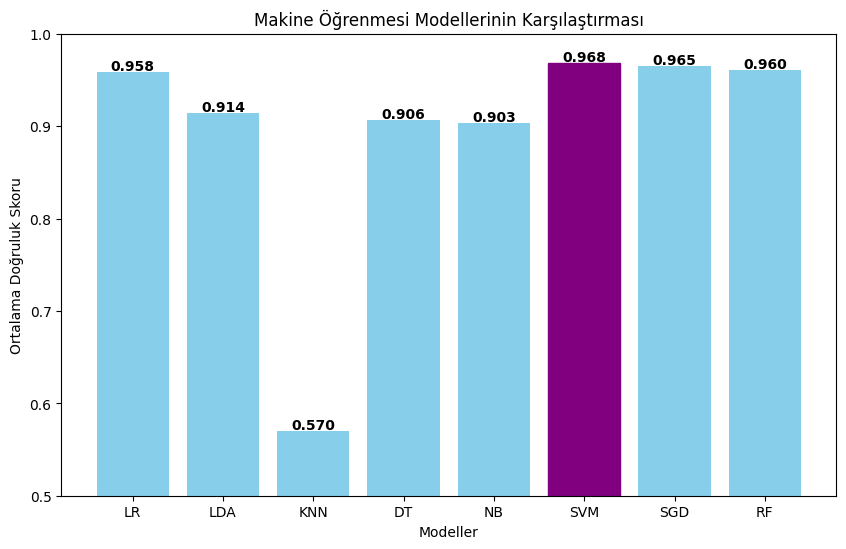

In [16]:
import matplotlib.pyplot as plt

# Model isimleri
names = ['LR', 'LDA', 'KNN', 'DT', 'NB', 'SVM', 'SGD', 'RF']

# Ortalama doğruluk skorları (elde ettiğimiz sonuçlara göre giriyoruz)
scores = [0.9581, 0.9140, 0.5701, 0.9064, 0.9029, 0.9681, 0.9650, 0.9603]

# Grafik çizimi
plt.figure(figsize=(10, 6))
bars = plt.bar(names, scores, color='skyblue')
plt.xlabel("Modeller")
plt.ylabel("Ortalama Doğruluk Skoru")
plt.title("Makine Öğrenmesi Modellerinin Karşılaştırması")

# En yüksek skoru farklı renkte gösterelim (SVM)
bars[5].set_color('purple')

# Barların üstüne skorları yazalım
for i, v in enumerate(scores):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center', fontweight='bold')

plt.ylim(0.5, 1.0)
plt.show()


Yukarıdaki çubuk grafikte çeşitli makine öğrenmesi algoritmalarının ortalama doğruluk skorlarını karşılaştırdık. En yüksek başarı oranına sahip olan **SVM (Support Vector Machine)** modeli, mor renkte vurgulandı.Bu grafikten de yola çıkarak SVM 
modelini kullanalım.


In [17]:
from sklearn.svm import SVC
#Model nesnesini oluşturalım
model = SVC()

#Modeli eğitelim(fit edelim)
model.fit(X_train, y_train)

SVC()

Modelimiz artık hazır.Şimdi model gerçekten öğrendi mi diye test verisiyle tahmin yapalım.
Yani modele daha önce hiç göstermediğimiz e-postaları(X_test) verip kontrol edelim.

In [18]:
y_pred = model.predict(X_test)

Şimdi modelin ne kadar başarılı olduğunu anlamak için skorları ölçelim.
***Confusion matrix:***
Doğru ve yanlış tahminleri tablo olarak gösterir.
***Classification report:***
Precision,recall,f1-score gibi başarı skorlarını hesaplar.

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
#Karışıklık matrisi(doğru-yanlış sınıflar)
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
#Başarı skorları
print("\n Classification Report: \n", classification_report(y_test,y_pred))

Confusion Matrix:
 [[2140   69]
 [  30 1488]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2209
           1       0.96      0.98      0.97      1518

    accuracy                           0.97      3727
   macro avg       0.97      0.97      0.97      3727
weighted avg       0.97      0.97      0.97      3727



***Precision(Kesinlik):*** Phishing olarak işaretlenen e-postaların %96'sı gerçekten phishing.
***Recall (Duyarlılık):*** Gerçek phishinh e-postalarının %98'i doğru şekilde tespit edilmiş.
***Accuracy (Doğruluk):*** Modelin genel doğruluğu %97'dir.


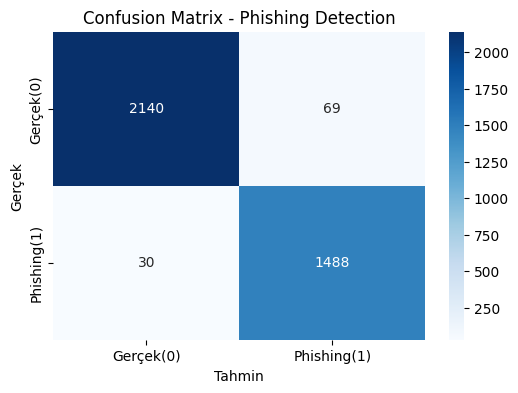

In [22]:
#Şimdi de Confusion Matrix'i görselleştirelim
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#Matris değerlerini hesaplayalım
cm = confusion_matrix(y_test, y_pred)
#Etiketleri isteğe göre belirleyelim
labels = ['Gerçek(0)','Phishing(1)']
#Görselleştirelim
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix - Phishing Detection')
plt.show()



Yukarıdaki ısı haritası, modelin sınıflandırma başarısını görsel olarak göstermektedir. Bu tabloya göre:

- **2140** adet gerçek (genuine) e-posta doğru bir şekilde **gerçek** olarak sınıflandırılmıştır.(**True Negative**)
- **1488** adet phishing (sahte) e-posta doğru şekilde **phishing** olarak yakalanmıştır.(**True Positive**)
- **69** adet gerçek e-posta, yanlışlıkla phishing olarak tahmin edilmiştir (**False Positive**).
- **30** adet phishing e-posta ise yanlışlıkla gerçek olarak tahmin edilmiştir (**False Negative**).

Bu sonuçlara göre model:
- Gerçek e-postaları yüksek başarıyla tanımaktadır (0 sınıfı için doğruluk: %97).
- Phishing e-postaların çoğunu başarıyla yakalamaktadır (1 sınıfı için recall: %98).
- Yanlış alarm oranı (%3) oldukça düşüktür.
- Genel doğruluk oranı **%97** olup, bu modelin phishing tespiti için güvenilir olduğunu göstermektedir.

> **Sonuç:** Confusion matrix, modelin sahte e-postaları etkili bir şekilde ayırt edebildiğini açıkça göstermektedir.

# Sonuç ve Değerlendirme
Proje,phishing(oltalama) e-postalarını tespit edebilen bir makine öğrenmesi sistemi geliştirmeyi amaçlamaktaydı.En iyi doğruluk oranı %96.8 ile SVM modelinden elde edildi ve model yüksek precision(%96) ve yüksek recall(%98) değerleri ile güçlü bir performans sergiledi.